<a href="https://colab.research.google.com/github/leechaerin03/-5-/blob/main/paln%EB%AA%A8%EB%8D%B8%EB%B2%A0%EC%9D%B4%EC%8A%A4Action%ED%8C%8C%EC%9D%B8%ED%8A%9C%EB%8B%9D_4%EB%B9%84%ED%8A%B8%EC%96%91%EC%9E%90%ED%99%94%EB%BA%80%EB%B2%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
! pip install wandb

In [ ]:
import wandb

# LLM 모니터링
wandb.login(key="9ed675d942c745bf3fdf524bba1fcd137e6e81ab")
run = wandb.init(project='Fine tuning  LAM2', job_type='training', anonymous='allow')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)
from peft import (
    get_peft_model,
    LoraConfig
)


# --- 1. 모델 및 토크나이저 ID ---
hub_repo_name = "leeChaerin/PlanModel_v1"


# --- 3. 모델 로드 (수정됨) ---
# 4비트 양자화 설정을 적용하고, .to("cuda") 대신 device_map="auto" 사용
model = AutoModelForCausalLM.from_pretrained(
    hub_repo_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
)

# --- 4. 토크나이저 로드 (수정됨) ---
# padding_side는 그대로 두되, pad_token은 None일 경우에만 설정
tokenizer = AutoTokenizer.from_pretrained(hub_repo_name, padding_side="left")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Tokenizer pad_token이 eos_token으로 설정되었습니다.")

# --- 5. (★필수★) LoRA 어댑터 적용 ---
# 이 부분이 '...does not require grad...' 에러를 해결합니다.
# 4비트로 '동결된' 모델 위에 학습 가능한 새 레이어(어댑터)를 추가합니다.

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"], # PlanModel_v1의 기반 모델(Kanana) 기준
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# 모델에 LoRA 어댑터 적용
model = get_peft_model(model, peft_config)

# --- 6. 준비 완료 ---
print("\n--- LoRA 어댑터 적용 후 학습 가능한 파라미터 ---")
model.print_trainable_parameters()


--- LoRA 어댑터 적용 후 학습 가능한 파라미터 ---
trainable params: 23,003,136 || all params: 2,109,982,464 || trainable%: 1.0902


In [ ]:
tokenizer.encode(tokenizer.eos_token)
#base모델은 eos 토큰이 128001임 왜 차이나는진 모르겠음

[128000, 128009]

In [ ]:
messages = [
    {"role": "system",
    "content": """You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
    1.  **Plan Generation:**
      If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
      You MUST respond with the complete `{"task_plan": [{"step_id": , "description":}...]}` JSON for the entire task.
      If the user requests a specific course, include the specific course name in the plan description.

    2.  **Action Generation:**
      If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
      You MUST respond with the single `{"action": {...}}` JSON for that specific step.
      For input actions, ensure the `value` field matches the specific data from the plan."""}
]

tokens = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print(tokens)
#print(tokenizer.encode(tokens, add_special_tokens=False))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
    1.  **Plan Generation:**
      If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
      You MUST respond with the complete `{"task_plan": [{"step_id": , "description":}...]}` JSON for the entire task.
      If the user requests a specific course, include the specific course name in the plan description.

    2.  **Action Generation:**
      If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
      You MUST respond with the single `{"action": {...}}` JSON for that specific step.
      For input actions, ensure the `value` field matches the specific data from the plan.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
SYSTEM_TEXT = (
    """You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
    1.  **Plan Generation:**
      If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
      You MUST respond with the complete `{"task_plans": [...]}` JSON for the entire task.

    2.  **Action Generation:**
      If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
      You MUST respond with the single `{"action": {...}}` JSON for that specific step."""
)

In [ ]:
import json
from google.colab import files
from datasets import load_dataset, Dataset

print("train_data.jsonl 업로드...")
uploaded = files.upload()
DATA_PATH = list(uploaded.keys())[0]

fixed_data = []
print("데이터를 로드하며 타입을 문자열로 통일합니다...")
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            row = json.loads(line)

            if isinstance(row.get('prompt'), dict):
                row['prompt'] = json.dumps(row['prompt'], ensure_ascii=False)

            if isinstance(row.get('output'), dict):
                row['output'] = json.dumps(row['output'], ensure_ascii=False)

            if 'prompt' in row and 'output' in row:
                fixed_data.append(row)

        except json.JSONDecodeError:
            print(f"JSON 파싱 오류 무시: {line}")

raw = Dataset.from_list(fixed_data)

print("\n--- 수정된 데이터로 로드 성공! ---")
print(raw)
print("\n[Row 0 예시] (Query -> Plan)")
print(raw[0])
print("\n[Row 1 예시] (Plan+State -> Action)")
print(raw[1])
print(f"\n총 {len(raw)}개 데이터 로드 완료.")

train_data.jsonl 업로드...


Saving test.jsonl to test (2).jsonl
데이터를 로드하며 타입을 문자열로 통일합니다...

--- 수정된 데이터로 로드 성공! ---
Dataset({
    features: ['prompt', 'output'],
    num_rows: 15
})

[Row 0 예시] (Query -> Plan)
{'prompt': '{"user_request": "불교동아리"}', 'output': '{"task_plan": [{"step_id": "1", "task_plan": "좌측 메뉴에서 \'학생신청(기타)\'를 펼친다"}, {"step_id": "2", "task_plan": "하위 메뉴 \'불교동아리가입\'을 클릭한다"}]}'}

[Row 1 예시] (Plan+State -> Action)
{'prompt': '{"user_request": "불교동아리", "task_plan": "좌측 메뉴에서 \'학생신청(기타)\'를 펼친다", "step_id": "1", "observations": {"sidebar": [{"label": "개인정보수집동의", "expanded": false, "checked": false, "sub_items": []}, {"label": "【학생신청】신청함", "expanded": false, "checked": false, "sub_items": []}, {"label": "【학생신청】진행함", "expanded": false, "checked": false, "sub_items": []}, {"label": "【학생신청】완료함", "expanded": false, "checked": false, "sub_items": []}, {"label": "학생신청(기타)", "expanded": false, "checked": false, "sub_items": []}, {"label": "학적/확인서", "expanded": false, "checked": false, "sub_items": []}, {"label

In [ ]:
import json
from torch.utils.data import Dataset, DataLoader
import torch

qna_list = []

SYSTEM_TEXT = (
     """You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
    1.  **Plan Generation:**
      If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
      You MUST respond with the complete `{"task_plan": [{"step_id": , "description":}...]}` JSON for the entire task.
      If the user requests a specific course, include the specific course name in the plan description.

    2.  **Action Generation:**
      If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
      You MUST respond with the single `{"action": {...}}` JSON for that specific step.
      For input actions, ensure the `value` field matches the specific data from the plan."""
)

for i in range(len(raw)):
    state = raw[i]["prompt"]   # 사용자 입력(프롬프트)
    action = raw[i]["output"]  # 정답(assistant 응답)

    # 1) messages에는 system + user만!
    messages = [
        {"role": "system", "content": SYSTEM_TEXT},
        {"role": "user",   "content": state},
    ]

    # 2) 마지막 user까지 템플릿 적용 + assistant가 생성될 자리 열기
    prompt_ids = tokenizer.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True
    )

    # 3) 정답 토큰은 별도로 인코딩해서 뒤에 붙임 (eos 권장)
    answer_ids = tokenizer.encode(
        (action or "") + (tokenizer.eos_token or ""),
        add_special_tokens=False
    )

    # 4) concat
    input_ids = prompt_ids + answer_ids

    # (선택) 평가/디버그용으로 원문 문자열도 보관하고 싶다면:
    prompt_str = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    answer_str = ((action or "") + (tokenizer.eos_token or ""))
    input_str  = prompt_str + answer_str

    qna_list.append({
        "prompt_ids": prompt_ids,
        "answer_ids": answer_ids,
        "input_ids":  input_ids,
        "prompt_str": prompt_str,
        "answer_str": answer_str,
        "input_str":  input_str,
    })

# 길이 통계(패딩 전에 참고용)
max_length = max(len(x["input_ids"]) for x in qna_list)
print("samples:", len(qna_list))
print("max_length:", max_length)


samples: 15
max_length: 1451


In [ ]:
pad_id = tokenizer.pad_token_id
assert pad_id is not None, "pad_token이 설정돼 있어야 합니다."

class SFTDataset(Dataset):
    def __init__(self, items, max_length):
        self.inputs = []
        self.attns  = []
        self.labels = []

        for ex in items:
            ids = ex["input_ids"]

            # 트렁케이션/패딩
            if len(ids) > max_length:
                ids = ids[-max_length:]  # 뒤를 보존(정답이 뒤에 있으므로)

            attn = [1] * len(ids)
            pad_len = max_length - len(ids)
            if pad_len > 0:
                ids  = ids  + [pad_id] * pad_len
                attn = attn + [0]      * pad_len

            # 레이블: 프롬프트는 -100, 정답만 레이블
            # 정답 시작 위치 = 프롬프트 길이
            prompt_len = len(ex["prompt_ids"])
            # (트렁케이션이 있었다면 prompt_len도 재계산이 필요하지만
            # 위에서 뒤를 남겼으니 보통 prompt_len <= max_length를 만족)
            labels = [-100] * len(ids)
            for pos in range(prompt_len, len(ex["input_ids"])):
                if pos >= max_length:
                    break
                labels[pos] = ids[pos]

            self.inputs.append(torch.tensor(ids))
            self.attns.append(torch.tensor(attn))
            self.labels.append(torch.tensor(labels))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.attns[idx], self.labels[idx]

dataset = SFTDataset(qna_list, max_length=min(1024, max_length))
loader  = DataLoader(dataset, batch_size=2, shuffle=True)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device = "cpu"
torch.manual_seed(123)
model.to(device)

cuda


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 1792, padding_idx=128001)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1792, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1792, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (

In [ ]:
# 파인튜닝 전에 어떻게 대답하는지 확인
questions = [ qna['q_ids'] for qna in qna_list]

for i, q_ids in enumerate(questions):

    model.eval()
    with torch.no_grad():
        output = model.generate(
            torch.tensor([q_ids]).to("cuda"),
            max_new_tokens=100,
            #attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")
    print("----------\n")

Q0: system

You are a helpful AI assistant for Dongguk Univ nDRIMS. Your job is to understand the user's request, formulate a step-by-step plan, and then output the correct action based on the current system observations (state)+ step-by-step plan + the user's requestuser

{"user_request": "불교동아리", "task_plan": "좌측 메뉴에서 '학생신청(기타)'를 펼친다", "step_id": "1", "observations": {"sidebar": [{"id": "d7", "label": "학생신청(기타)", "expanded": false}, {"id": "e5", "label": "공지사항", "expanded": true, "sub_items": [{"id": "lq", "label": "공지사항조회", "checked": true}]}]}}assistant

### 현재 상태 및 계획:
- **현재 좌측 메뉴 상태**: "학생신청(기타)"는 펼쳐져 있지 않음.
- **현재 작업 계획**: 좌측 메뉴에서 '학생신청(기타)'를 펼친다.
- **현재 관찰 상태**: "학생신청(기타)"는 펼쳐져 있지 않으며, "공지사항조회" 항목이 체크된 상태.

### 단계별 실행 계획
----------

Q1: system

You are a helpful AI assistant for Dongguk Univ nDRIMS. Your job is to understand the user's request, formulate a step-by-step plan, and then output the correct action based on the current system observations (state)+ step-by-step plan 

KeyboardInterrupt: 

In [ ]:
losses = []

global_step = 0

model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

for epoch in range(10):
    total = 0.0
    for input_ids, attn_mask, labels in loader:
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)
        labels    = labels.to(device)

        optimizer.zero_grad()
        out = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        loss = out.loss
        loss.backward()
        optimizer.step()
        total += loss.item()

        global_step += 1

        wandb.log({
            "train/loss_step": loss.item(),
            "epoch": epoch,
            "step": global_step,
        })

    avg_loss = total / len(loader)
    losses.append(avg_loss)
    print(f"epoch {epoch} | loss {avg_loss:.4f}")

    wandb.log({
        "train/loss_epoch": avg_loss,
        "epoch": epoch,
    })

    # ★ LoRA 어댑터 저장 (중요)
    save_dir = f"./adapters/epoch_{epoch:03d}"
    model.save_pretrained(save_dir)      # ← 어댑터 가중치 저장
    # (선택) 토크나이저도 함께 보관하면 편함
    tokenizer.save_pretrained(save_dir)
    print(f"[saved] LoRA adapter -> {save_dir}")

wandb.finish()

epoch 0 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_000
epoch 1 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_001
epoch 2 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_002
epoch 3 | loss 0.0903
[saved] LoRA adapter -> ./adapters/epoch_003
epoch 4 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_004
epoch 5 | loss 0.0726
[saved] LoRA adapter -> ./adapters/epoch_005
epoch 6 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_006
epoch 7 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_007
epoch 8 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_008
epoch 9 | loss nan
[saved] LoRA adapter -> ./adapters/epoch_009


epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train/loss_epoch,█ ▁
train/loss_step,▄ ▄▄▂▁▁▁▁ ▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁ ▂ ▁▁█▄▂
epoch,9
step,80
train/loss_epoch,nan
train/loss_step,nan


In [ ]:
from IPython.display import IFrame, display


display(IFrame(run.url, width=1200, height=720))


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_repo = "leeChaerin/PlanModel_v1"
adapter_path = "./adapters/epoch_009"

tokenizer = AutoTokenizer.from_pretrained(base_repo)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    base_repo,
    torch_dtype=torch.float16,   # 또는 float32 (CPU면)
    device_map="auto",
    trust_remote_code=True,
)

model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval()

print("모델 로드 완료")


모델 로드 완료


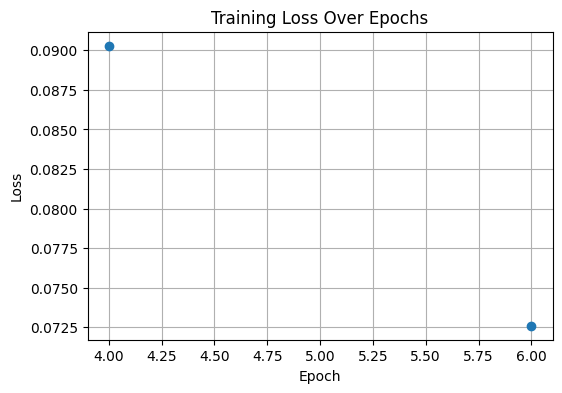

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [ ]:
import re, json, torch
from transformers import StoppingCriteria, StoppingCriteriaList

SYSTEM_TEXT = (
     """You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
    1.  **Plan Generation:**
      If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
      You MUST respond with the complete `{"task_plan": [{"step_id": , "description":}...]}` JSON for the entire task.
      If the user requests a specific course, include the specific course name in the plan description.

    2.  **Action Generation:**
      If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
      You MUST respond with the single `{"action": {...}}` JSON for that specific step.
      For input actions, ensure the `value` field matches the specific data from the plan."""
)

def build_inputs(user_prompt: str):
    messages = [
        {"role": "system", "content": SYSTEM_TEXT},
        {"role": "user",   "content": user_prompt},
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(text, return_tensors="pt")
    return {k: v.to(model.device) for k, v in inputs.items()}

# 1) 균형 검사 유틸
def is_balanced_json_fragment(s: str) -> bool:
    in_str = False
    esc = False
    stack = []
    for ch in s:
        if in_str:
            if esc:
                esc = False
            elif ch == '\\':
                esc = True
            elif ch == '"':
                in_str = False
            continue
        else:
            if ch == '"':
                in_str = True
            elif ch == '{':
                stack.append('}')
            elif ch == '[':
                stack.append(']')
            elif ch in ('}', ']'):
                if not stack or stack[-1] != ch:
                    return False
                stack.pop()
    return len(stack) == 0 and len(s) > 0

# 2) 가장 긴 균형 잡힌 JSON 덩어리 추출
def longest_balanced_json(text: str) -> str | None:
    # 첫 { 또는 [ 부터 스캔
    start = None
    for i, ch in enumerate(text):
        if ch in '{[':
            start = i
            break
    if start is None:
        return None

    in_str = False
    esc = False
    stack = []
    last_good = None
    for i, ch in enumerate(text[start:], start=start):
        if in_str:
            if esc:
                esc = False
            elif ch == '\\':
                esc = True
            elif ch == '"':
                in_str = False
        else:
            if ch == '"':
                in_str = True
            elif ch == '{':
                stack.append('}')
            elif ch == '[':
                stack.append(']')
            elif ch in ('}', ']'):
                if not stack or stack[-1] != ch:
                    break
                stack.pop()
                if not stack:
                    last_good = i + 1
    return text[start:last_good].strip() if last_good else None

# 3) 스톱 조건 교체: 단일 '}' 대신 '균형 JSON이면 멈춤'
from transformers import StoppingCriteria, StoppingCriteriaList
import re, torch

class StopOnBalancedJSON(StoppingCriteria):
    def __init__(self, tokenizer, lookback_tokens=400):
        self.tok = tokenizer
        self.lookback_tokens = lookback_tokens
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        txt = self.tok.decode(input_ids[0][-self.lookback_tokens:], skip_special_tokens=True)
        # 마지막 JSON 시작 후보를 대략 잡아 균형 확인
        m = re.search(r'([\{\[].*)$', txt, flags=re.DOTALL)
        cand = m.group(1) if m else txt
        return is_balanced_json_fragment(cand)

stoppers = StoppingCriteriaList([StopOnBalancedJSON(tokenizer)])
# 4) generate_json 후처리 교체: 정규식 candidates 대신 longest_balanced_json 사용
def generate_json(user_prompt: str, max_new_tokens=256, do_sample=False):
    inputs = build_inputs(user_prompt)
    input_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=0.7 if do_sample else None,
            top_p=0.9 if do_sample else None,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            stopping_criteria=stoppers,
        )

    # 입력 길이 이후(신규 생성분)만 디코딩
    new_tokens = out_ids[0, input_len:]
    text = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    # 균형 잡힌 JSON만 잘라서 파싱
    jb = longest_balanced_json(text)
    if jb is None:
        return text  # 디버그용으로 원문 반환
    try:
        return json.loads(jb)
    except Exception:
        return jb  # 파싱 실패 시 문자열로 반환(디버그)


In [ ]:
# ---- 테스트 ----
plan_prompt = "{'user_request': '자퇴신청'}"
plan_result = generate_json(plan_prompt)
print(plan_result)

{'task_plan': [{'step_id': 1, 'task_plan': "좌측 메뉴에서 '【학생신청】신청함'를 클릭한다."}, {'step_id': '2', 'task_plan': "화면에서 '[학적]자퇴신청' 항목을 찾아 해당 그리드의 행번호를 확인한다."}]}


In [ ]:
#-------모델 쓰는 방법 가이드----------

# 1. 사용자 입력을 넣고, plan을 생성
import json

user_req = input("무엇을 하고 싶나요? (예: 휴학신청): ").strip()

plan_payload = {"user_request": user_req}
plan_prompt = json.dumps(plan_payload, ensure_ascii=False)

plan_result = generate_json(plan_prompt, do_sample=False)
print("[PLAN RESULT]")
print(plan_result)

무엇을 하고 싶나요? (예: 휴학신청): 자퇴신청
[PLAN RESULT]
{'task_plan': [{'step_id': 1, 'task_plan': "좌측 메뉴에서 '【학생신청】신청함'를 클릭한다."}, {'step_id': '2', 'task_plan': "화면에서 '[학적]자퇴신청' 항목을 찾아 해당 그리드의 행번호를 확인한다."}]}


In [ ]:
import json, ast

def extract_steps(plan_result):
    # 1) dict면 바로 사용
    if isinstance(plan_result, dict):
        steps = plan_result.get("task_plan") or plan_result.get("task_plans") or []
        return [(int(s.get("step_id", i+1)), str(s.get("task_plan",""))) for i, s in enumerate(steps)]

    # 2) 문자열이면 JSON → 실패 시 literal_eval 순서로 파싱
    s = str(plan_result).strip()
    try:
        obj = json.loads(s)
    except Exception:
        obj = ast.literal_eval(s)  # '...' 스타일 파싱

    steps = obj.get("task_plan") or obj.get("task_plans") or []
    return [(int(s.get("step_id", i+1)), str(s.get("task_plan",""))) for i, s in enumerate(steps)]

print(extract_steps(plan_result))



[(1, "좌측 메뉴에서 '【학생신청】신청함'를 클릭한다."), (2, "화면에서 '[학적]자퇴신청' 항목을 찾아 해당 그리드의 행번호를 확인한다.")]


In [ ]:
import json

# 1) 정규식으로 뽑은 결과 예시 (이미 너가 만든 result)
# result = [(1, "좌측 메뉴에서 '【학생신청】신청함'를 클릭한다."), (2, "..."), (3, "...")]

# 여기에 state 넣으면 됨
obs_map = {
    1: {
        "sidebar": [{"id": "18555", "label": "【학생신청】신청함", "expanded": False, "checked": False}]
    },
    2: {
        "sidebar": [{"id": "18555", "label": "【학생신청】신청함", "expanded": False, "checked": True}]
    },
    3: {
        "sidebar": [{"id": "fc", "label": "수업/강의평가", "expanded": True, "checked": True, "sub_items": [{"id": "fm", "label": "종합강의시간표조회", "checked": True}]}]
    }
}

def build_action_prompt(user_request: str, step_id: int, task_plan: str, observations: dict | None):
    payload = {
        "user_request": user_request,
        "task_plan": task_plan,
        "step_id": str(step_id),
    }
    if observations is not None:
        payload["observations"] = observations
    # 문자열 깨짐 방지: 반드시 json.dumps 사용
    return json.dumps(payload, ensure_ascii=False)

def run_actions_from_regex_result(result_list, user_request="휴학신청", obs_map=None, max_new_tokens=256):
    outputs = []
    for sid, tplan in result_list:
        obs = (obs_map or {}).get(sid)
        action_prompt = build_action_prompt(user_request, sid, tplan, obs)
        out = generate_json(action_prompt, max_new_tokens=max_new_tokens, do_sample=False)
        outputs.append((sid, tplan, out))
    return outputs

# ---- 실행 ----
actions = run_actions_from_regex_result(extract_steps(plan_result), user_request="휴학신청", obs_map=obs_map, max_new_tokens=256)

for sid, tplan, action in actions:
    print("------------------------------------------------")
    print(f"[STEP {sid}] {tplan}")
    print("[ACTION RESULT]\n", action)


------------------------------------------------
[STEP 1] 좌측 메뉴에서 '【학생신청】신청함'를 클릭한다.
[ACTION RESULT]
 {'function': 'click', 'control_label': '【학생신청】신청함', 'control_type': 'tree-item', 'value': '', 'args': {'role': 'treeitem', 'aria-label': '【학생신청】신청함'}, 'status': 'CONTINUE'}
------------------------------------------------
[STEP 2] 화면에서 '[학적]자퇴신청' 항목을 찾아 해당 그리드의 행번호를 확인한다.
[ACTION RESULT]
 {'function': 'find', 'control_label': '[학적]자퇴신청', 'control_type': 'gridcell', 'value': '', 'args': {'role': 'gridcell', 'aria-label': '[학적]자퇴신청'}, 'status': 'FINISH'}


In [ ]:
from huggingface_hub import login
login()  # ▶ 허깅페이스 토큰 입력 (Settings > Access Tokens에서 생성한 토큰)


In [ ]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from huggingface_hub import HfApi, create_repo, upload_folder

BASE_REPO = "leeChaerin/PlanModel_v1"      # 학습 때 사용한 베이스
ADAPTER_DIR = "./adapters/epoch_009"       # 저장된 LoRA 어댑터 폴더
HF_REPO_ID = "leeChaerin/ActionModel_v5"  # 새로 만들 허깅페이스 repo 이름

# (1) 허브에 리포지토리 생성(이미 있으면 skip=True)
create_repo(repo_id=HF_REPO_ID, private=False, exist_ok=True)

# (2) 어댑터 폴더 업로드
upload_folder(
    repo_id=HF_REPO_ID,
    folder_path=ADAPTER_DIR,
    path_in_repo=".", # 루트에 업로드
)
print(f"[OK] LoRA adapter uploaded -> https://huggingface.co/{HF_REPO_ID}")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../epoch_009/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

  ...adapter_model.safetensors:   1%|          |  559kB / 92.1MB            

[OK] LoRA adapter uploaded -> https://huggingface.co/leeChaerin/ActionModel_v5


In [ ]:
action_prompt = """{
 'user_request': '휴학신청',
 'task_plan': "좌측 메뉴에서 '학생신청(기타)'를 펼친다",
 'step_id': '1',
 'observations': {'sidebar': [{'id':'d7','label':'학생신청(기타)','expanded': false}]}]}
}"""
print(generate_json(action_prompt))

{'function': 'click', 'control_label': '학생신청(기타)', 'control_type': 'tree-item', 'value': '', 'args': {'role': 'treeitem', 'aria-label': '학생신청(기타)'}, 'status': 'CONTINUE'}


In [ ]:
import torch, json, re
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

device = "cuda" if torch.cuda.is_available() else "cpu"

BASE_REPO   = "leeChaerin/PlanModel_v1"   # 학습 시 썼던 베이스
ADAPTER_DIR = "./adapters/epoch_002"      # 저장해둔 LoRA 어댑터 폴더로 변경

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(BASE_REPO, padding_side="left", trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_REPO,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

model = PeftModel.from_pretrained(base_model, ADAPTER_DIR)
model.eval()
print("[OK] Adapter loaded:", ADAPTER_DIR)


[OK] Adapter loaded: ./adapters/epoch_002


In [ ]:
!pip install outlines

In [ ]:
# 형식 고정화 라이브러리 넣기
from pydantic import BaseModel, Field
from typing import Dict, Any, Literal
from outlines.models.transformers import Transformers
from outlines import Generator

# 'args'에 들어갈 내용 정의
class ClickArgs(BaseModel):
    role: str
    aria_label: str = Field(alias="aria-label")

# 최종 출력 JSON 구조 정의
class ActionModel(BaseModel):
    function: str
    control_label: str
    control_type: str
    args: ClickArgs
    status: Literal["CONTINUE", "FINISH"]


from peft import PeftModel
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

hub_repo_name = "leeChaerin/PlanModel_v1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    hub_repo_name,
    quantization_config=bnb_config,
    device_map="auto"
)
# 토크나이저도 불러와야 합니다.
tokenizer = AutoTokenizer.from_pretrained(hub_repo_name)

adapter_path = "./model_epoch_009"

# 'model' 객체가 여기서 새로 생성됩니다.
model = PeftModel.from_pretrained(base_model, adapter_path)

# --- (C) 추론 준비 ---
model.eval()
print(f"'{adapter_path}'에서 어댑터를 성공적으로 로드했습니다.")

outlines_model = Transformers(model=model, tokenizer=tokenizer)
action_generator = Generator(outlines_model, ActionModel)

user_input = input("요청사항을 입력하세요: ")

messages = [
    {"role": "system",
    "content": "You are a helpful AI assistant for Dongguk Univ nDRIMS. Your job is to understand the user's request, formulate a step-by-step plan, and then output the correct action based on the current system observations (state)."},
    {"role": "user", "content": """
    {'user_request': '{user_input}',
     'observations': {'sidebar': [{'id': 'd7', 'label': '학생신청(기타)', 'expanded': false},{'id': 'e5', 'label': '공지사항', 'expanded': true, 'sub_items': [{'id': 'lq', 'label': '공지사항조회', 'checked': true}]}]}
    """},
]

prompt_string = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True  # '[ASSISTANT]' 프롬프트를 자동으로 추가
)

print(f"---  Action 생성 ---")
model.eval()
with torch.no_grad():
    # action_generator가 프롬프트를 받아 Pydantic 객체를 반환합니다.
    action_result = action_generator(prompt_string, max_new_tokens=256)


# --- 3. 결과 출력 ---
# action_result는 Pydantic 객체이므로, .model_dump_json()을 사용해
# 깔끔한 JSON 문자열로 변환합니다.

print("\n--- Outlines가 강제한 JSON 출력 ---")
try:
    print(action_result.model_dump_json(indent=2))
except Exception as e:
    print(f"JSON 변환 오류: {e}")
    print(action_result) # Pydantic 객체 원본 출력



messages = [
    {"role": "system",
    "content": "You are a helpful AI assistant for Dongguk Univ nDRIMS. Your job is to understand the user's request, formulate a step-by-step plan, and then output the correct action based on the current system observations (state)."},
    {"role": "user", "content": """
    {'user_request': '{user_input}',
    'observations': {"sidebar": [{"id": "d7", "label": "학생신청(기타)", "expanded": true, "sub_items": [{"id": "ee", "label": "불교동아리가입", "checked": false}]}]}}}
    """},
]

prompt_string = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True  # '[ASSISTANT]' 프롬프트를 자동으로 추가
)

print(f"---  Action2 생성 ---")
model.eval()
with torch.no_grad():
    # action_generator가 프롬프트를 받아 Pydantic 객체를 반환합니다.
    action_result = action_generator(prompt_string, max_new_tokens=256)


# --- 3. 결과 출력 ---
# action_result는 Pydantic 객체이므로, .model_dump_json()을 사용해
# 깔끔한 JSON 문자열로 변환합니다.

print("\n--- Outlines가 강제한 JSON 출력 ---")
try:
    print(action_result.model_dump_json(indent=2))
except Exception as e:
    print(f"JSON 변환 오류: {e}")
    print(action_result) # Pydantic 객체 원본 출력


'./model_epoch_009'에서 어댑터를 성공적으로 로드했습니다.


KeyboardInterrupt: 

In [ ]:
def generate_once(user_prompt: str, max_new_tokens=256, do_sample=False, temperature=0.7, top_p=0.9):
    inputs = build_inputs(user_prompt)
    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature if do_sample else None,
            top_p=top_p if do_sample else None,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )
    text = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    return text

# 모델 출력에서 마지막 assistant 부분만(=정답 JSON) 뽑고 싶으면:
ASSISTANT_SPLIT_RE = re.compile(r"(?:<<assistant>>|assistant\n|assistant:)", re.IGNORECASE)

def extract_assistant_text(full_text: str):
    # 템플릿에 따라 전체 대화가 포함될 수 있어, 뒤쪽 JSON을 heuristics로 추출
    # 단순화: 중괄호 블록 중 마지막 JSON 객체/배열 추출
    candidates = re.findall(r"(\{.*\}|\[.*\])", full_text, flags=re.DOTALL)
    return candidates[-1].strip() if candidates else full_text.strip()

def try_parse_json(s: str):
    try:
        return json.loads(s), None
    except Exception as e:
        return None, e


In [ ]:
# (A) Plan Generation 테스트
plan_prompt = "{'user_request': '휴학신청'}"
gen_plan = generate_once(plan_prompt, do_sample=False)
print("\n[RAW OUTPUT - PLAN]\n", gen_plan)

only_json = extract_assistant_text(gen_plan)
parsed, err = try_parse_json(only_json)
print("\n[PARSED JSON - PLAN]\n", parsed if err is None else only_json)




[RAW OUTPUT - PLAN]
 system

You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
    1.  **Plan Generation:**
      If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
      You MUST respond with the complete `{"task_plans": [...]}` JSON for the entire task.

    2.  **Action Generation:**
      If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
      You MUST respond with the single `{"action": {...}}` JSON for that specific step.user

{'user_request': '휴학신청'}assistant

{"task_plan": [{"step_id": 1, "task_plan": "좌측 메뉴에서 '졸업' 탭을 연다."}, {"step_id": 2, "task_plan": "'취득학점취소/변경신청' 메뉴를 클릭하여 페이지로 이동한다."}, {"step_id": 3, "task_plan": "'취득학점취소' 박스의 '학적' 항목의 체크박스를 해제한다."}, {"step_id": 4, "task_plan": "'취소' 버튼을 클릭하여 신청 버튼을 활성화한다."}, {"step_id": 5, "task_plan": "취소 버튼을 클릭한

In [ ]:
import torch
import json
from pydantic import BaseModel, Field
from typing import Dict, Any, Literal, List
from outlines.models.transformers import Transformers
from outlines import Generator

# (가정: 'model'과 'tokenizer'는 이전 셀에서 로드 완료됨)
if 'model' not in globals() or 'tokenizer' not in globals():
    print("🚨 오류: 'model' 또는 'tokenizer'가 로드되지 않았습니다.")
    print("이 셀을 실행하기 전에 [14]번 셀 (모델 로드)을 먼저 실행해주세요.")
    # Colab에서 셀 실행을 중단하는 가장 간단한 방법
    raise NameError("'model' or 'tokenizer' not defined.")


# --- 1. Pydantic 스키마 2개 정의 ---

# ⭐️ Task A (Plan 생성)를 위한 스키마
class Step(BaseModel):
    step_id: int
    description: str

class TaskPlan(BaseModel):
    task_plan: List[Step]

# ⭐️ Task B (Action 생성)를 위한 스키마
class ClickArgs(BaseModel):
    role: str
    aria_label: str = Field(alias="aria-label")

class ActionModel(BaseModel):
    function: str
    control_label: str
    control_type: str
    args: ClickArgs
    status: Literal["CONTINUE", "FINISH"]

# --- 2. Outlines 제너레이터 2개 생성 ---
# (두 제너레이터 모두 동일한 'model' 객체를 사용)

print(f"래핑할 모델 객체: {model.__class__.__name__}") # PeftModelForCausalLM
outlines_model = Transformers(model=model, tokenizer=tokenizer)

# Task A (Plan) 제너레이터
plan_generator = Generator(outlines_model, TaskPlan)
print("✅ 'Plan 생성기' 준비 완료.")

# Task B (Action) 제너레이터
action_generator = Generator(outlines_model, ActionModel)
print("✅ 'Action 생성기' 준비 완료.")

# --- 3. ⚡️ 상태(State) 정의 ⚡️ ---

user_query = "불교동아리"

# ⭐️ State 1: 1단계 (Plan 실행 전)의 '초기 상태'
# (Cell [12]의 예시와 동일: 학생신청(기타)가 닫혀 있음)
initial_state_json = {
    "sidebar": [
    {
      "label": "개인정보수집동의",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "【학생신청】신청함",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "【학생신청】진행함",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "【학생신청】완료함",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "학생신청(기타)",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "학적/확인서",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "수강신청",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "수업/강의평가",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "성적",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "장학",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "등록",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "교직",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "졸업",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "공학교육인증",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "현장실습",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "예비군",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "교육센터",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "써머스쿨",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "남산학사",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "충무학사",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "고양학사",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "공지사항",
      "expanded": True,
      "checked": False,
      "sub_items": [
        {
          "label": "공지사항조회",
          "expanded": False,
          "checked": True,
          "sub_items": []
        }
      ]
    }
  ]
}

# ⭐️ State 2: 1단계 Action("학생신청(기타)" 클릭)이 실행된 '이후의 상태'
# (전체 JSON으로 확장된 버전. Python 변수이므로 true/false가 아닌 True/False 사용)
state_after_step_1_json = {
    "sidebar": [
    {
      "label": "개인정보수집동의",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "【학생신청】신청함",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "【학생신청】진행함",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "【학생신청】완료함",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "학생신청(기타)",
      "expanded": True,
      "checked": True,
      "sub_items": [
        {
          "label": "봉사소감문등록",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "신행활동신청",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "신행활동마일리지점수확인",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "학생신행활동기준표안내",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "교직이수신청/취소신청",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "교육봉사활동시간등록",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "성인지교육신청",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "응급처치및심폐소생술 실습신청",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "교직인적성검사 신청",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "교직기타 서비스신청",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "DIY설문조사",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "교류상황및파견정보등록",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "국외교류인정성적등록",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "해외학술탐방일정관리",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "근로장학근로시간등록",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "불교동아리가입",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "학생증개인정보동의",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "DEIS학부모서비스제공동의",
          "expanded": False,
          "checked": False,
          "sub_items": []
        },
        {
          "label": "투표하기",
          "expanded": False,
          "checked": False,
          "sub_items": []
        }
      ]
    },
    {
      "label": "학적/확인서",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "수강신청",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "수업/강의평가",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "성적",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "장학",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "등록",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "교직",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "졸업",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "공학교육인증",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "현장실습",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "예비군",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "교육센터",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "써머스쿨",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "남산학사",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "충무학사",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "고양학사",
      "expanded": False,
      "checked": False,
      "sub_items": []
    },
    {
      "label": "공지사항",
      "expanded": False,
      "checked": False,
      "sub_items": [
        {
          "label": "공지사항조회",
          "expanded": False,
          "checked": False,
          "sub_items": []
        }
      ]
    }
  ]
}


# --- 4. ⚡️ 자동화 파이프라인(루프) 실행 ⚡️ ---

model.eval()
with torch.no_grad():

    # === 1단계: Query ➡️ Plan ===
    print(f"\n--- 1단계: '{user_query}'로 Plan 생성 ---")

    plan_messages = [
        {"role": "system",
      "content": """You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
      1.  **Plan Generation:**
        If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
        You MUST respond with the complete `{"task_plans": [...]}` JSON for the entire task.

      2.  **Action Generation:**
        If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
        You MUST respond with the single `{"action": {...}}` JSON for that specific step."""},
        {"role": "user_request", "content": user_query}
    ]
    plan_prompt_string = tokenizer.apply_chat_template(
        plan_messages, tokenize=False, add_generation_prompt=True
    )

    generated_plan_obj = None # Pydantic 객체를 담을 변수
    try:
        # Pydantic 객체를 반환하도록 시도
        generated_plan_str_or_obj = plan_generator(plan_prompt_string, max_new_tokens=256)

        # Pydantic 객체가 반환되었는지, 문자열이 반환되었는지 확인
        if isinstance(generated_plan_str_or_obj, str):
            print(f"⚠️ 1단계 경고: Outlines가 문자열 반환. 수동 파싱 시도...")
            print(f"   반환된 원본(str): {generated_plan_str_or_obj}")
            json_data = json.loads(generated_plan_str_or_obj)
            generated_plan_obj = TaskPlan.model_validate(json_data)
        else:
            generated_plan_obj = generated_plan_str_or_obj # Pydantic 객체

        print("   ✅ 1단계 Plan 생성 성공!")
        print(generated_plan_obj.model_dump_json(indent=2))

    except Exception as e:
        print(f"🚨 1단계 오류: Plan 생성 또는 파싱 실패: {e}")
        # 1단계가 실패하면 2단계를 실행할 수 없으므로 중단
        raise Exception("1단계 Plan 생성 실패")


    # === 2단계: (Plan + State) ➡️ Action (루프 실행) ===

    # ⭐️ 첫 번째 상태는 '초기 상태'로 설정
    current_state = initial_state_json

    # 생성된 Plan의 모든 단계를 순회
    for i, step in enumerate(generated_plan_obj.task_plan):

        step_description = step.description
        print(f"\n--- 2단계 (Step {i+1}): '{step_description}'으로 Action 생성 ---")

        # ⭐️ Task B 프롬프트 (현재 state를 사용)
        action_messages = [
            {"role": "system",
    "content": """You are a specialized AI agent for Dongguk Univ nDRIMS. Your task is to analyze the user's input structure and perform one of two specific tasks:
    1.  **Plan Generation:**
      If the user 'prompt' contains **only** a `user_request` (e.g., "불교동아리 가입"), this is a request for a plan.
      You MUST respond with the complete `{"task_plans": [...]}` JSON for the entire task.

    2.  **Action Generation:**
      If the user 'prompt' contains a `task_plan` (current step) AND `observations` (current state), this is a request for an action.
      You MUST respond with the single `{"action": {...}}` JSON for that specific step."""},
            {"role": "user", "content": f"""
            {{'user_request': '불교동아리',
              'task_plan': '{step_description}',
              'step_id': f'{i+1}',
              'observations': {json.dumps(current_state, ensure_ascii=False)}}}
            """},
        ]
        action_prompt_string = tokenizer.apply_chat_template(
            action_messages, tokenize=False, add_generation_prompt=True
        )

        action_result_obj = None # Pydantic 객체를 담을 변수
        try:
            action_result_str_or_obj = action_generator(action_prompt_string, max_new_tokens=256)

            # Pydantic 객체/문자열 반환 여부 확인
            if isinstance(action_result_str_or_obj, str):
                print(f"⚠️ 2단계 경고: Outlines가 문자열 반환. 수동 파싱 시도...")
                print(f"   반환된 원본(str): {action_result_str_or_obj}")
                json_data = json.loads(action_result_str_or_obj)
                action_result_obj = ActionModel.model_validate(json_data)
            else:
                action_result_obj = action_result_str_or_obj # Pydantic 객체

            print("\n--- ⭐️ Action JSON 출력 (Step {i+1}) ⭐️ ---")
            print(action_result_obj.model_dump_json(indent=2))

            # === 3단계: ⭐️ 상태 업데이트 (시뮬레이션) ⭐️ ===
            if action_result_obj.status == "FINISH":
                print("\n[INFO] 'FINISH' 상태이므로 루프를 종료합니다.")
                break
            else:
                # (시뮬레이션) 1단계가 끝났으니, 2단계를 위해 상태를 업데이트합니다.
                print("[INFO] (시뮬레이션) Action 실행... 다음 단계를 위해 상태를 업데이트합니다.")

                # ⭐️⭐️⭐️
                # 1단계("학생신청(기타)" 클릭)가 실행되었으므로,
                # 다음 루프에서 사용할 상태를 'state_after_step_1_json'로 변경합니다.
                # ⭐️⭐️⭐️
                current_state = state_after_step_1_json

        except Exception as e:
            print(f"🚨 2단계 (Step {i+1}) 실행 중 오류: {e}")
            break # 오류 발생 시 루프 중단

    print("\n--- 🚀 전체 파이프라인 실행 완료 ---")

래핑할 모델 객체: PeftModelForCausalLM
✅ 'Plan 생성기' 준비 완료.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


✅ 'Action 생성기' 준비 완료.

--- 1단계: '불교동아리'로 Plan 생성 ---


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


⚠️ 1단계 경고: Outlines가 문자열 반환. 수동 파싱 시도...
   반환된 원본(str): {"task_plan": [{"step_id": 1, "description": "좌측 메뉴에서 '학생신청(기타)'를 클릭한다."}, {"step_id": 2, "description": "'불교동아리가입' 메뉴를 클릭한다."}]}
   ✅ 1단계 Plan 생성 성공!
{
  "task_plan": [
    {
      "step_id": 1,
      "description": "좌측 메뉴에서 '학생신청(기타)'를 클릭한다."
    },
    {
      "step_id": 2,
      "description": "'불교동아리가입' 메뉴를 클릭한다."
    }
  ]
}

--- 2단계 (Step 1): '좌측 메뉴에서 '학생신청(기타)'를 클릭한다.'으로 Action 생성 ---


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


⚠️ 2단계 경고: Outlines가 문자열 반환. 수동 파싱 시도...
   반환된 원본(str): {"function": "click", "control_label": "학생신청(기타)", "control_type": "tree-item", "args": {"role": "treeitem", "aria-label": "학생신청(기타)"}, "status": "CONTINUE"}

--- ⭐️ Action JSON 출력 (Step {i+1}) ⭐️ ---
{
  "function": "click",
  "control_label": "학생신청(기타)",
  "control_type": "tree-item",
  "args": {
    "role": "treeitem",
    "aria_label": "학생신청(기타)"
  },
  "status": "CONTINUE"
}
[INFO] (시뮬레이션) Action 실행... 다음 단계를 위해 상태를 업데이트합니다.

--- 2단계 (Step 2): ''불교동아리가입' 메뉴를 클릭한다.'으로 Action 생성 ---
⚠️ 2단계 경고: Outlines가 문자열 반환. 수동 파싱 시도...
   반환된 원본(str): {"function": "click", "control_label": "불교동아리가입", "control_type": "tree-item", "args": {"role": "treeitem", "aria-label": "불교동아리가입"}, "status": "CONTINUE"}

--- ⭐️ Action JSON 출력 (Step {i+1}) ⭐️ ---
{
  "function": "click",
  "control_label": "불교동아리가입",
  "control_type": "tree-item",
  "args": {
    "role": "treeitem",
    "aria_label": "불교동아리가입"
  },
  "status": "CONTINUE"
}
[INFO] (시뮬레이션) A

In [ ]:
user_input = input("요청사항을 입력하세요: ")

messages = [
    {"role": "system",
    "content": "You are a helpful AI assistant for Dongguk Univ nDRIMS. Your job is to understand the user's request, formulate a step-by-step plan, and then output the correct action based on the current system observations (state)+ step-by-step plan + the user's request"},
    {"role": "user", "content": """
    {'user_request': '{user_input}',
     'observations': "sidebar": [
    {
      "label": "개인정보수집동의",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "【학생신청】신청함",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "【학생신청】진행함",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "【학생신청】완료함",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "학생신청(기타)",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "학적/확인서",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "수강신청",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "수업/강의평가",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "성적",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "장학",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "등록",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "교직",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "졸업",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "공학교육인증",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "현장실습",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "예비군",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "교육센터",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "써머스쿨",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "남산학사",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "충무학사",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "고양학사",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "공지사항",
      "expanded": true,
      "checked": false,
      "sub_items": [
        {
          "label": "공지사항조회",
          "expanded": false,
          "checked": true,
          "sub_items": []
        }
      ]
    }
  ]
}}]}
    """},
]

model.eval()
with torch.no_grad():
    ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)

    input_ids = torch.tensor([ids]).to("cuda")
    input_length = input_ids.shape[1]

    output = model.generate(
        input_ids,
        max_new_tokens=64,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
    )

    generated_tokens = output[0][input_length:]
    extracted_response = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print("\n--- Action step1 ---")
print(extracted_response)

messages = [
    {"role": "system",
    "content": "You are a helpful AI assistant for Dongguk Univ nDRIMS. Your job is to understand the user's request, formulate a step-by-step plan, and then output the correct action based on the current system observations (state)."},
    {"role": "user", "content": """
    {'user_request': '{user_input}',
     'observations':  "sidebar": [
    {
      "label": "개인정보수집동의",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "【학생신청】신청함",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "【학생신청】진행함",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "【학생신청】완료함",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "학생신청(기타)",
      "expanded": true,
      "checked": true,
      "sub_items": [
        {
          "label": "봉사소감문등록",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "신행활동신청",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "신행활동마일리지점수확인",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "학생신행활동기준표안내",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "교직이수신청/취소신청",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "교육봉사활동시간등록",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "성인지교육신청",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "응급처치및심폐소생술 실습신청",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "교직인적성검사 신청",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "교직기타 서비스신청",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "DIY설문조사",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "교류상황및파견정보등록",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "국외교류인정성적등록",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "해외학술탐방일정관리",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "근로장학근로시간등록",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "불교동아리가입",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "학생증개인정보동의",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "DEIS학부모서비스제공동의",
          "expanded": false,
          "checked": false,
          "sub_items": []
        },
        {
          "label": "투표하기",
          "expanded": false,
          "checked": false,
          "sub_items": []
        }
      ]
    },
    {
      "label": "학적/확인서",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "수강신청",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "수업/강의평가",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "성적",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "장학",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "등록",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "교직",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "졸업",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "공학교육인증",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "현장실습",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "예비군",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "교육센터",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "써머스쿨",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "남산학사",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "충무학사",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "고양학사",
      "expanded": false,
      "checked": false,
      "sub_items": []
    },
    {
      "label": "공지사항",
      "expanded": true,
      "checked": false,
      "sub_items": [
        {
          "label": "공지사항조회",
          "expanded": false,
          "checked": false,
          "sub_items": []
        }
      ]
    }
  ]
}}]}}}
    """},
]

model.eval()
with torch.no_grad():
    ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)

    input_ids = torch.tensor([ids]).to("cuda")
    input_length = input_ids.shape[1]

    output = model.generate(
        input_ids,
        max_new_tokens=64,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
    )

    generated_tokens = output[0][input_length:]
    extracted_response2 = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print("\n--- Action step2 ---")
print(extracted_response2)
# extracted_response 변수에 JSON 형태의 문자열이 저장됨
# {'function': 'click', 'control_label': '취득학점확인서조회', ... 'status': 'FINISH'}

KeyboardInterrupt: Interrupted by user